In [52]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option("display.max_columns", None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [53]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

In [54]:
# Separate target and features in train dataset
target = train['Survived']
train = train.drop(columns=['Survived'])

In [55]:
# Feature extraction from name.

# Creating the rank column based from the name.
accepted_ranks = ['Mr', 'Mrs', 'Miss', 'Master', 'Other']
rank_transform = {'Mlle': 'Miss', 'Ms': 'Mrs', 'Mme': 'Mrs'}

train['Rank'] = pd.Categorical(train['Name'].apply(lambda x: x.split('.')[0].split(' ')[-1]).replace(rank_transform), categories=accepted_ranks).fillna('Other')
test['Rank'] = pd.Categorical(test['Name'].apply(lambda x: x.split('.')[0].split(' ')[-1]).replace(rank_transform), categories=accepted_ranks).fillna('Other')

In [56]:
# Drop non exploitable columns
unwanted_columns = ['Cabin', 'PassengerId', 'Name', 'Ticket']

train = train.drop(columns=unwanted_columns)
test = test.drop(columns=unwanted_columns)

In [57]:
# Embarked data imputation:
imputed_embarked_value = train['Embarked'].mode()[0]

train['Embarked'] = train['Embarked'].fillna(imputed_embarked_value)
test['Embarked'] = test['Embarked'].fillna(imputed_embarked_value)

# Age data imputation:
imputed_age_value = train['Age'].mean()

train['Age'] = train['Age'].fillna(imputed_age_value)
test['Age'] = test['Age'].fillna(imputed_age_value)

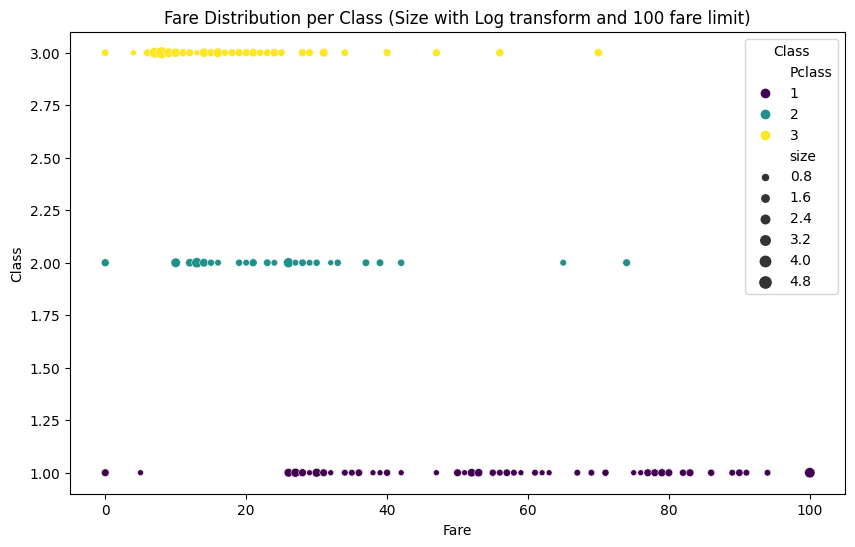

In [58]:
# Outliners

# Redo plot and add size:
plotting = train[['Pclass', 'Fare']]
plotting['Fare_transformed'] = plotting['Fare'].apply(lambda x: int(np.round(np.minimum(100, x), 0)))
plotting = plotting.groupby(['Pclass', 'Fare_transformed'], as_index=False).size()

plt.figure(figsize=(10, 6))
plotting['size'] = np.log1p(plotting['size'])
sns.scatterplot(x='Fare_transformed', y='Pclass', size='size', data=plotting, hue='Pclass', palette='viridis')
    
plt.title('Fare Distribution per Class (Size with Log transform and 100 fare limit)')
plt.xlabel('Fare')
plt.ylabel('Class')
plt.legend(title='Class')
plt.show()

In [59]:
# Fixing Fare outliners
# 0 are for sure outliners, several others to treat.

# Consider free Fare to be outliners.
train.loc[train['Fare'] == 0, 'Fare'] = None
test.loc[test['Fare'] == 0, 'Fare'] =None

# Age imputation from rank mean
mean_fare_per_class = train.groupby(['Pclass'])['Age'].mean().to_dict()

train['Fare'] = train.apply(lambda row: mean_fare_per_class[row['Pclass']] if pd.isnull(row['Fare']) else row['Fare'], axis=1)
test['Fare'] = test.apply(lambda row: mean_fare_per_class[row['Pclass']] if pd.isnull(row['Fare']) else row['Fare'], axis=1)

In [60]:
# Dealing with Skewness
for col in train.select_dtypes(['float', 'int']).columns:
    print(f'Col {col}: {train[col].skew()}')

train['Fare'] = np.log(train['Fare'])
test['Fare'] = np.log(test['Fare'])

Col Pclass: -0.6305479068752845
Col Age: 0.4344880940129925
Col SibSp: 3.6953517271630565
Col Parch: 2.7491170471010933
Col Fare: 4.81108583312383


In [61]:
# Data encoding
numeric_cols = train.select_dtypes(['float', 'int']).columns
categorical_cols = train.select_dtypes(['category', 'object']).columns

# Data encoding:
encoder = OneHotEncoder()

train_encoded_features = encoder.fit_transform(train[categorical_cols])
test_encoded_features = encoder.transform(test[categorical_cols])

train_encoded = pd.concat([
    train.drop(columns=categorical_cols),
    pd.DataFrame(train_encoded_features.toarray(), columns=encoder.get_feature_names_out())
], axis=1) 

test_encoded = pd.concat([
    test.drop(columns=categorical_cols),
    pd.DataFrame(test_encoded_features.toarray(), columns=encoder.get_feature_names_out())
], axis=1)

# Data normalization
scaler = MinMaxScaler()
train_encoded[numeric_cols] = scaler.fit_transform(train_encoded[numeric_cols])
test_encoded[numeric_cols] = scaler.transform(test_encoded[numeric_cols])

In [62]:
# Model exploration:
random_state = 111

In [63]:
# Imports and display results function

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def display_results(y_real, y_pred):
    print(f"Accuracy: {accuracy_score(y_real, y_pred)}")

    print(classification_report(y_real, y_pred))

    cm = confusion_matrix(y_real, y_pred)

    palette = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=palette);

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Died', 'Survived']) 
    ax.yaxis.set_ticklabels(['Died', 'Survived'])

In [64]:
# Split train dataset in Train and Validation
X_train, X_test, y_train, y_test = train_test_split(train_encoded, target, test_size=0.3, random_state=random_state)

Accuracy: 0.8246268656716418
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       171
           1       0.78      0.71      0.75        97

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268



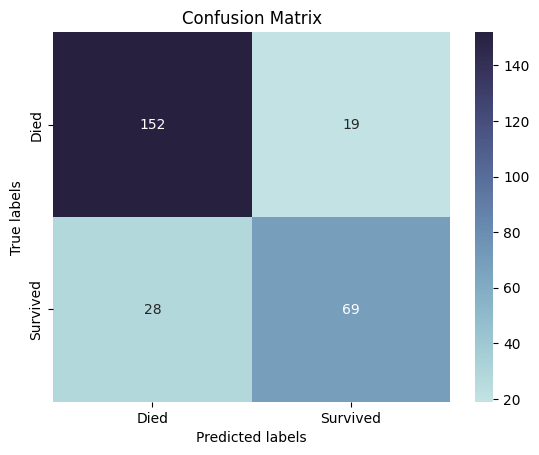

In [65]:
# Linear Regression (LogisticRegression)
logistic_regression_model = LogisticRegression(random_state=random_state)

logistic_regression_model.fit(X_train, y_train)

y_pred = logistic_regression_model.predict(X_test)

display_results(y_test, y_pred)